# Lesson 1: detecting disturbances using COLD and S-CCD
**Author: Su Ye (remotesensingsuy@gmail.com)**

**Time series datasets: Harmonized Landsat-Sentinel (HLS) datasets**

**Application: forest fire in Sichuan, China**

## COLD (latest CCDC)

The COntinuous monitoring of Land Disturbance (COLD) algorithm is the latest version for Continuous Change Detection and Classification (CCDC), developed for monitoring land surface dynamics using satellite imagery, particularly the Landsat archive. COLD was proposed by Zhe et al (2020), which made several important improvements over the original CCDC proposed by Zhe et al (2014). COLD/CCDC models the temporal trajectory of surface reflectance at the pixel level by fitting all available observations with a set of harmonic regression functions that capture seasonal variation, along with linear terms to represent long-term trends. This enables the algorithm to continuously track both gradual and abrupt land surface changes.

When new observations arrive, COLD/CCDC evaluates whether they deviate significantly from the modeled trajectory. If a consistent deviation beyond statistical thresholds is detected, a break is identified, signaling a potential disturbance or land cover change event (detection). By recording multiple breaks per pixel, COLD/CCDC supports monitoring of historical changes, such as forest disturbances, urban expansion, agricultural rotation, or vegetation recovery. At the same time, COLD/CCDC extracts the harmonic coefficients for each temporal segment determined by breaks, which will be used for segment-based land-cover classification (classification).  

References:

*Zhu, Z., Zhang, J., Yang, Z., Aljaddani, A. H., Cohen, W. B., Qiu, S., & Zhou, C. (2020). Continuous monitoring of land disturbance based on Landsat time series. Remote Sensing of Environment, 238, 111116.*

*Zhu, Z., & Woodcock, C. E. (2014). Continuous change detection and classification of land cover using all available Landsat data. Remote sensing of Environment, 144, 152-171.*

---

### COLD Break detection

The Ya’an Fire, one of the most destructive wildfires in China, occurred in Ya’an County, Sichuan Province, on March 22. Here shows using `COLD` to detect a pixel-based HLS time series under the 2024 Ya’an Fire:

In [1]:
import numpy as np
import os
import pathlib
import pandas as pd

# Imports from this package
from pyxccd import cold_detect


TUTORIAL_DATASET = (pathlib.Path.cwd() / 'datasets').resolve() # modify it as you need
assert TUTORIAL_DATASET.exists()
in_path = TUTORIAL_DATASET/ '1_hls_sc.csv'

# read example csv for HLS time series
data = pd.read_csv(in_path)

# split the array by the column
dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas, sensor = data.to_numpy().copy().T
cold_result = cold_detect(dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas)

# convert ordinal date to human readable date
break_date = pd.Timestamp.fromordinal(cold_result[0]["t_break"]).strftime('%Y-%m-%d')
print(f"The break detected is {break_date}")
print("COLD results is: ")
print(cold_result)

The break detected is 2024-03-23
COLD results is: 
[(735600, 738960, 738968, 1, 472,  8, 100, [[ 1.6766739e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00], [ 3.6711215e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00], [ 3.5981775e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00], [-1.8439887e+04,  2.7444632e+02,  0.0000000e+00,  0.0000000e+00,  2.4501804e+01, -2.7643259e+01,  6.1835299e+00, -1.1128180e+01], [ 1.2269283e+03,  0.0000000e+00,  0.0000000e+00,  9.2912989e+00,  0.0000000e+00, -1.4118568e+01,  0.0000000e+00, -5.2788010e+00], [ 7.1484528e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00], [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+

COLD is a per-pixel algorithm, and the fundamental outputs are the temporal segments of the input data defined by the break. After running `cold_detect`, the output is a 1-d structural array. The length of the array denotes the number of the segments for this pixel (for this case, we got two segments and one break). Each element include 10 attributes as the following: 
* t_start: Ordinal date when series model gets started
* t_end: Ordinal date when series model gets ended
* t_break: Ordinal date when the break is detected (the observation next to t_end)
* pos: Location of each time series model using the date code as user define. For example, in the lesson 4, pos = i * n_cols + j, where i is the 0-based row number, j is the 1-based column number, to guarantee the pos starts from 1. For a HLS pixel at 1000th row, and 1st col, pos is 3660*1000+1 
* num_obs: Number of clear observations used for model estimation
* category: Quality of the model estimation (what model is used, what process is used)

    (first digit)
    0 - normal model (no change);
    1 - change at the beginning of time series model;
    2 - change at the end of time series model;
    3 - disturbance change in the middle;
    4 - fmask fail scenario;
    5 - permanent snow scenario;
    6 - outside user mask

    (second digit)
    1 - model has only constant term;
    4 - model has 3 coefs + 1 const;
    6 - model has 5 coefs + 1 const;
    8 - model has 7 coefs + 1 const;
* change_prob: Probability of a pixel that have undergone change (between 0 and 100)
* coefs: 2-d array of shape (7, 8) containing multispectral harmonic coefficients obtained from Lasso regression. Each row corresponds to a specific spectral band in the following fixed order: blue, green, red, NIR, SWIR1, SWIR2, and thermal (rows 0 to 6 respectively).

Note:**the slope coefficients (located in the second column of the array) have been scaled by a factor of 10,000** in pyxccd to optimize storage efficiency when using float32 precision. Before using these coefficients for harmonic curve prediction, the slope values must be restored to their original scale by dividing them by 10,000.

* rmse: 1-d array of shape (7,), multispectral RMSE of predicted and actiual observations
* magnitude: 1-d array of shape (7,), multispectral median difference between model prediction and observations of a window of conse observations following detected breakpoint

### COLD break categorization

Considering the spectral break is not necessarily linked to the disturbances, but also possibly related to climate variability, succession, and even data noise, the COLD algorithm provides a quick rule-based solution to determine the category of the break (1-disturbance, 2-regrowth, 3-reafforestation). For more details, please refers to Section 3.3.7 in the COLD paper ("Continuous monitoring of land disturbance based on Landsat time series")

Pyxccd provides this function for determining the break category:

In [2]:
from pyxccd.utils import getcategory_cold
print(f"The category for the first break is {getcategory_cold(cold_result, 0)}") # 0 means the first break, 1 means the second, etc

The category for the first break is 1


### COLD Visualization

Next, we will show how to plot the NIR time series and the COLD break detection results (note that COLD combines green, red, NIR, swir1, swir2 to determine the break while we only used NIR to exemplify the curve fitting and break detection):

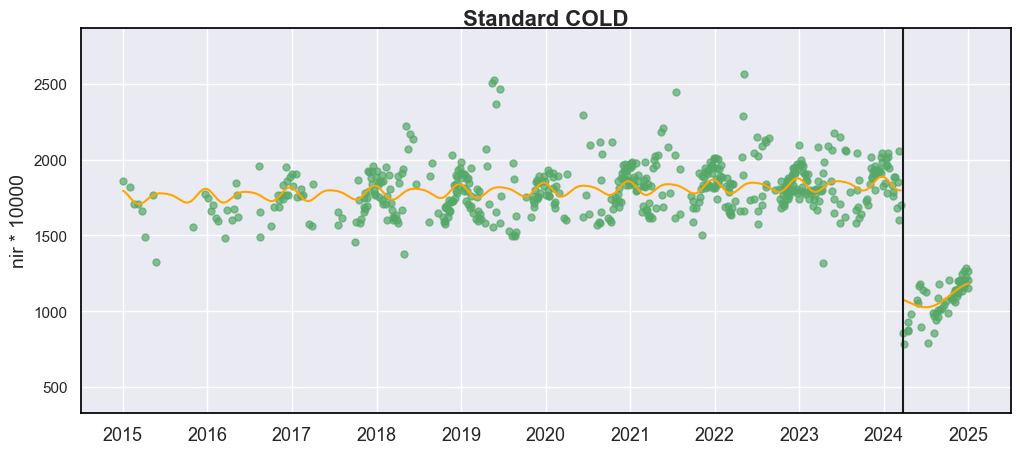

In [3]:
from pyxccd.common import cold_rec_cg
from pyxccd.utils import read_data, getcategory_cold

from datetime import date
from typing import List, Tuple, Dict, Union, Optional
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

def display_cold_result(
    data: np.ndarray,
    band_names: List[str],
    band_index: int,
    cold_result: cold_rec_cg,
    axe: Axes,
    title: str = 'COLD',
    plot_kwargs: Optional[Dict] = None
) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    Compare COLD and SCCD change detection algorithms by plotting their results side by side.
    
    This function takes time series remote sensing data, applies both COLD algorithms,
    and visualizes the curve fitting and break detection results. 
    
    Parameters:
    -----------
    data : np.ndarray
        Input data array with shape (n_observations, n_bands + 2) where:
        - First column: ordinal dates (days since January 1, AD 1)
        - Next n_bands columns: spectral band values
        - Last column: QA flags (0-clear, 1-water, 2-shadow, 3-snow, 4-cloud)
        
    band_names : List[str]
        List of band names corresponding to the spectral bands in the data (e.g., ['red', 'nir'])
        
    band_index : int
        0-based index of the band to plot (e.g., 0 for first band, 1 for second band)
    
    axe: Axes
        An Axes object represents a single plot within that Figure
    
    title: Str
        The figure title. The default is "COLD"
        
    plot_kwargs : Dict, optional
        Additional keyword arguments to pass to the display function. Possible keys:
        - 'marker_size': size of observation markers (default: 5)
        - 'marker_alpha': transparency of markers (default: 0.7)
        - 'line_color': color of model fit lines (default: 'orange')
        - 'font_size': base font size (default: 14)
        
    Returns:
    --------
    Tuple[plt.Figure, List[plt.Axes]]
        A tuple containing the matplotlib Figure object and a list of Axes objects
        (top axis is COLD results, bottom axis is SCCD results)
    
    """
    w = np.pi * 2 / 365.25

    # Set default plot parameters
    default_plot_kwargs: Dict[str, Union[int, float, str]] = {
        'marker_size': 5,
        'marker_alpha': 0.7,
        'line_color': 'orange',
        'font_size': 14
    }
    if plot_kwargs is not None:
        default_plot_kwargs.update(plot_kwargs)

    # Extract values with proper type casting
    font_size = default_plot_kwargs.get('font_size', 14)
    try:
        title_font_size = int(font_size) + 2
    except (TypeError, ValueError):
        title_font_size = 16 


    # Clean and prepare data
    data = data[np.all(np.isfinite(data), axis=1)]
    data_df = pd.DataFrame(data, columns=['dates'] + band_names + ['qa'])

    # Plot COLD results
    w = np.pi * 2 / 365.25
    slope_scale = 10000

    # Prepare clean data for COLD plot
    data_clean = data_df[(data_df['qa'] == 0) | (data_df['qa'] == 1)].copy()
    data_clean =  data_clean[(data_clean >= 0).all(axis=1) & (data_clean.drop(columns="dates") <= 10000).all(axis=1)]
    calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in data_clean["dates"]]
    data_clean.loc[:, 'dates_formal'] = calendar_dates
    
    # Calculate y-axis limits
    band_name = band_names[band_index]
    band_values = data_clean[data_clean['qa'] == 0][band_name]
    q01, q99 = np.quantile(band_values, [0.01, 0.99])
    extra = (q99 - q01) * 0.4
    ylim_low = q01 - extra
    ylim_high = q99 + extra

    # Plot COLD observations
    axe.plot(
        'dates_formal', band_name, 'go',
        markersize=default_plot_kwargs['marker_size'],
        alpha=default_plot_kwargs['marker_alpha'],
        data=data_clean
    )

    # Plot COLD segments
    for segment in cold_result:
        j = np.arange(segment['t_start'], segment['t_end'] + 1, 1)
        plot_df = pd.DataFrame({
            'dates': j,
            'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
            'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
            'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
            'trimodel': np.cos(3 * w * j) * segment['coefs'][band_index][6] + np.sin(3 * w * j) * segment['coefs'][band_index ][7]
        })
        plot_df['predicted'] = (
            plot_df['trend'] + 
            plot_df['annual'] + 
            plot_df['semiannual'] + 
            plot_df['trimodel']
        )

        # Convert dates and plot model fit
        calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
        plot_df.loc[:, 'dates_formal'] = calendar_dates
        g = sns.lineplot(
            x="dates_formal", y="predicted",
            data=plot_df,
            label="Model fit",
            ax=axe,
            color=default_plot_kwargs['line_color']
        )
        if g.legend_ is not None: 
            g.legend_.remove()

    # plot breaks
    for i in range(len(cold_result)):
        if  cold_result[i]['change_prob'] == 100:
            if getcategory_cold(cold_result, i) == 1:
                axe.axvline(pd.Timestamp.fromordinal(cold_result[i]['t_break']), color='k')
            else:
                axe.axvline(pd.Timestamp.fromordinal(cold_result[i]['t_break']), color='r')
    
    axe.set_ylabel(f"{band_name} * 10000", fontsize=default_plot_kwargs['font_size'])

    # Handle tick params with type safety
    tick_font_size = default_plot_kwargs['font_size']
    if isinstance(tick_font_size, (int, float)):
        axe.tick_params(axis='x', labelsize=int(tick_font_size)-1)
    else:
        axe.tick_params(axis='x', labelsize=13)  # fallback

    axe.set(ylim=(ylim_low, ylim_high))
    axe.set_xlabel("", fontsize=6)

    # Format spines
    for spine in axe.spines.values():
        spine.set_edgecolor('black')
    title_font_size = int(font_size) + 2 if isinstance(font_size, (int, float)) else 16
    axe.set_title(title, fontweight="bold", size=title_font_size, pad=2)
    
            
# Set up plotting style
sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 5))
# plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.1)

display_cold_result(data=np.stack((dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=3, cold_result=cold_result, axe=ax, title="Standard COLD")

### Lambda

You may not be fully satisfied with the current fitting curve (the yellow line). To address this, we provide the parameter `lam` to control the degree of regularization in Lasso regression. When `lam` = 0, all harmonic coefficients are estimated without penalty, and Lasso reduces to ordinary least squares (OLS) regression. Although this may produce a visually better fit to the observations, it can increase the risk of overfitting. For example, in the case shown below, an excessive break was detected in 2016 before the actual fire disturbance. This spurious break is most likely a commission error caused by overfitting in the curve fitting process. The default `lam` for COLD/S-CCD is 20, which was based upon numerous preliminary tests.

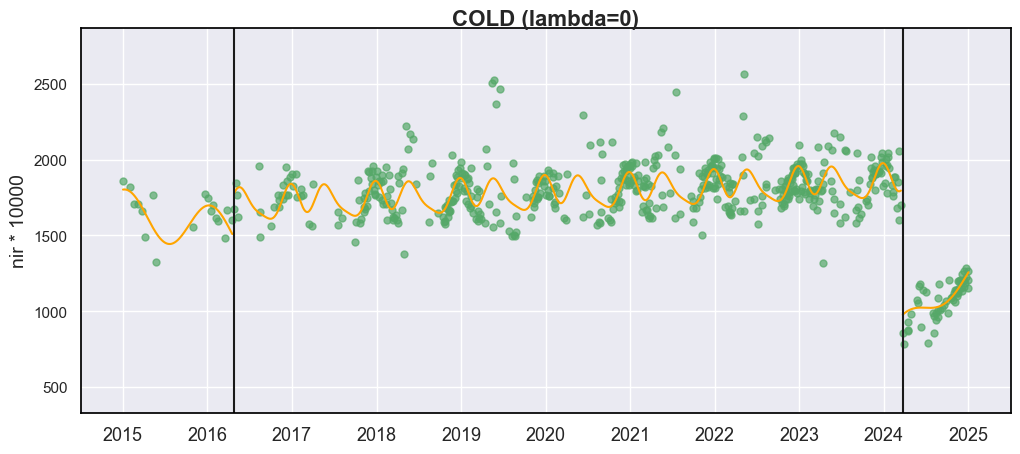

In [4]:
cold_result = cold_detect(dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas, lam=0)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 5))
# plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.1)

display_cold_result(data=np.stack((dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermals'], band_index=3, cold_result=cold_result, axe=ax, title="COLD (lambda=0)")

## S-CCD

Stochastic Continuous Change Detection (S-CCD) is an advanced variant of the Continuous Change Detection and Classification (CCDC) framework (Ye et al, 2021), designed to improve the timeliness and interpretation of land surface change detection. Unlike the original CCDC, which fits deterministic harmonic and linear models to the entire Landsat or Harmonized Landsat–Sentinel (HLS) time series, S-CCD introduces a stochastic updating mechanism that allows the model to evolve dynamically as new satellite observations arrive.

The key innovation of S-CCD is its use of recursive model updating (i.e., Kalman filter), which eliminates the need to refit the entire time series whenever new data are ingested. Instead, model coefficients (trend and seasonal parameters) are updated incrementally in a short-memory manner. This design makes the algorithm more computationally efficient and capable of operating in near real time. Moreover, S-CCD allows for outputting "states" for time-series components (annual, seminal, etc), thereby reaching a better capture for gradual change of seasonality and general trend in addition to break detection. For the scenario of retrospective time-series analysis, S-CCD has comparable detection accuracy with COLD.

Reference:

*Ye, S., Rogan, J., Zhu, Z., & Eastman, J. R. (2021). A near-real-time approach for monitoring forest disturbance using Landsat time series: Stochastic continuous change detection. Remote Sensing of Environment, 252, 112167.*

---

### S-CCD Break detection
The below is using S-CCD for the Ya'an fire site

In [5]:
from pyxccd import sccd_detect

# note that the standard s-ccd doesn't need thermal band for efficient computation, you could switch sccd_detect_flex which allows you to input any combination of bands if you really want to use thermal 
sccd_result = sccd_detect(dates, blues, greens, reds, nirs, swir1s, swir2s, qas)

break_date = pd.Timestamp.fromordinal(sccd_result.rec_cg[0]["t_break"]).strftime('%Y-%m-%d')
print(f"The break detected is {break_date}")
sccd_result

The break detected is 2024-03-23


SccdOutput(position=1, rec_cg=array([(735600, 738968, 441, [[ 5.7651807e+03, -7.5955360e+01,  2.8375614e-01,  5.1964793e+00, -2.0415826e+00, -6.4547181e+00], [ 1.6891670e+03, -1.8045355e+01,  2.2810047e+00,  1.6642979e+01, -5.6901956e+00, -1.3014506e+01], [ 1.2292332e+04, -1.6212231e+02,  3.5307232e+01,  1.7814684e+01, -1.0739973e+01, -1.8438562e+01], [-2.6667223e+04,  3.8507657e+02,  9.7016243e+01, -3.8088055e+00,  2.9747089e+01, -5.9461620e+01], [ 2.5863348e+04, -3.3480228e+02,  5.9306335e+01,  2.6777798e+01, -1.2760725e+01, -4.4620617e+01], [ 1.5446797e+04, -2.0042662e+02,  3.9952637e+01,  2.0489840e+01, -1.7458494e+01, -2.8435680e+01]], [28.350677, 33.288532, 34.144318, 94.36975 , 91.12302 , 59.044655], [ 231.40686,  157.6067 ,  277.8084 , -850.01636,  239.03906,  819.48413])],
      dtype={'names': ['t_start', 't_break', 'num_obs', 'coefs', 'rmse', 'magnitude'], 'formats': ['<i4', '<i4', '<i4', ('<f4', (6, 6)), ('<f4', (6,)), ('<f4', (6,))], 'offsets': [0, 4, 8, 12, 156, 180], 'it

S-CCD and COLD both detects the disturbance as '2024-03-23'. Actually, I have tested lots of cases. S-CCD and COLD often yielded very similar break detection results for retrospective analysis.

The output of S-CCD is a structured object containing six elements.
| Element | Datatype | Description |
| :------- | :------: | -------: |
| position   | int   | Position of current pixel, commonly coded as 10000*row+col   |
| rec_cg     | ndarray   | Temporal segment obtained by retrospective break detection  |
| nrt_mode   | int   | Current mode: the 1st digit indicate predictability and the 2nd is for `nrt_model` availability   |
| nrt_model  | ndarray   | Near real-time model for the last segment, which will be recursively updated|
| nrt_queue  | ndarray   | Near real-time observations stored in a queue when `nrt_model` is not initialized  |
| min_rmse   | ndarray   | Minimum rmse in CCDC to avoid overdetection from black body  |

Among them, `rec_cg` stores the results of historical segments identified through break detection. A key distinction from the COLD algorithm lies in the handling of the last segment of `rec_cg`: in S-CCD, this segment is either saved to `nrt_model` or to `nrt_queue` for near-real-time (NRT) applications. Consequently, the number of detected breaks equals the number of recorded segments. The assignment of the last segment depends on the status of the pixel, which is indicated by the variable `nrt_mode`. Specifically:

* If the initial model for the last segment has already been constructed, the second digit of `nrt_mode` is 1 (normal case) or 3 (snow condition). In this case, the segment is stored in `nrt_model`, and `nrt_queue` remains empty.

* If the initial model has not yet been constructed, the second digit of `nrt_mode` is 2 (normal case) or 4 (snow condition). In this case, `nrt_queue` begins storing new observations until sufficient data are available to initialize the model, while nrt_model remains empty.

This design ensures that S-CCD can flexibly handle both well-initialized segments and emerging segments, which is critical for timely and accurate near-real-time disturbance monitoring. We will introduce the details for this design in Lesson 7.


 The details for using S-CCD for the NRT scenario will be seen in Lesson 7. For this lesson, we will focus on the S-CCD-based retrospective analysis.

 ### S-CCD visualization
 

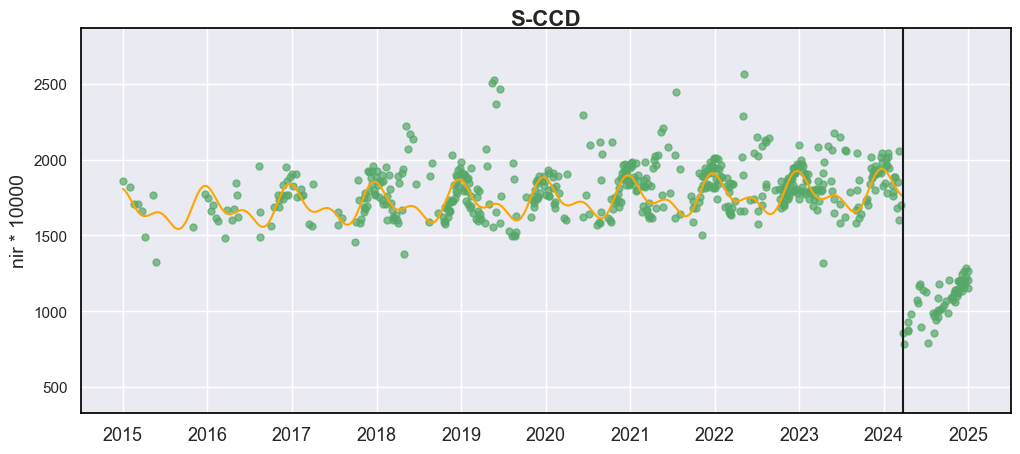

In [6]:
from pyxccd.common import SccdOutput
from pyxccd.utils import getcategory_sccd, defaults

def display_sccd_result(
    data: np.ndarray,
    band_names: List[str],
    band_index: int,
    sccd_result: SccdOutput,
    axe: Axes,
    title: str = 'S-CCD',
    plot_kwargs: Optional[Dict] = None
) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    Compare COLD and SCCD change detection algorithms by plotting their results side by side.
    
    This function takes time series remote sensing data, applies both COLD and SCCD algorithms,
    and visualizes the curve fitting and break detection results for comparison. 
    
    Parameters:
    -----------
    data : np.ndarray
        Input data array with shape (n_observations, n_bands + 2) where:
        - First column: ordinal dates (days since January 1, AD 1)
        - Next n_bands columns: spectral band values
        - Last column: QA flags (0-clear, 1-water, 2-shadow, 3-snow, 4-cloud)
        
    band_names : List[str]
        List of band names corresponding to the spectral bands in the data (e.g., ['red', 'nir'])
        
    band_index : int
        1-based index of the band to plot (e.g., 0 for first band, 1 for second band)
        
    sccd_result: SccdOutput
        Output of sccd_detect
    
    axe: Axes
        An Axes object represents a single plot within that Figure
    
    title: Str
        The figure title. The default is "S-CCD"
        
    plot_kwargs : Dict, optional
        Additional keyword arguments to pass to the display function. Possible keys:
        - 'marker_size': size of observation markers (default: 5)
        - 'marker_alpha': transparency of markers (default: 0.7)
        - 'line_color': color of model fit lines (default: 'orange')
        - 'font_size': base font size (default: 14)
        
    Returns:
    --------
    Tuple[plt.Figure, List[plt.Axes]]
        A tuple containing the matplotlib Figure object and a list of Axes objects
        (top axis is COLD results, bottom axis is SCCD results)
    
    """
    w = np.pi * 2 / 365.25

    # Set default plot parameters
    default_plot_kwargs: Dict[str, Union[int, float, str]] = {
        'marker_size': 5,
        'marker_alpha': 0.7,
        'line_color': 'orange',
        'font_size': 14
    }
    if plot_kwargs is not None:
        default_plot_kwargs.update(plot_kwargs)

    # Extract values with proper type casting
    font_size = default_plot_kwargs.get('font_size', 14)
    try:
        title_font_size = int(font_size) + 2
    except (TypeError, ValueError):
        title_font_size = 16 


    # Clean and prepare data
    data = data[np.all(np.isfinite(data), axis=1)]
    data_df = pd.DataFrame(data, columns=['dates'] + band_names + ['qa'])


    # Plot COLD results
    w = np.pi * 2 / 365.25
    slope_scale = 10000

    # Prepare clean data for COLD plot
    data_clean = data_df[(data_df['qa'] == 0) | (data_df['qa'] == 1)].copy()
    data_clean =  data_clean[(data_clean >= 0).all(axis=1) & (data_clean.drop(columns="dates") <= 10000).all(axis=1)]
    calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in data_clean["dates"]]
    data_clean.loc[:, 'dates_formal'] = calendar_dates
    
    # Calculate y-axis limits
    band_name = band_names[band_index]
    band_values = data_clean[data_clean['qa'] == 0 | (data_clean['qa'] == 1)][band_name]
    # band_values  = band_values[band_values <10000]
    q01, q99 = np.quantile(band_values, [0.01, 0.99])
    extra = (q99 - q01) * 0.4
    ylim_low = q01 - extra
    ylim_high = q99 + extra

    # Plot SCCD observations
    axe.plot(
        'dates_formal', band_name, 'go',
        markersize=default_plot_kwargs['marker_size'],
        alpha=default_plot_kwargs['marker_alpha'],
        data=data_clean
    )

    # Plot SCCD segments
    for segment in sccd_result.rec_cg:
        j = np.arange(segment['t_start'], segment['t_break'] + 1, 1)
        if len(segment['coefs'][band_index]) == 8:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
                'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
                'trimodal': np.cos(3 * w * j) * segment['coefs'][band_index][6] + np.sin(3 * w * j) * segment['coefs'][band_index][7]
            })
        else:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * segment['coefs'][band_index][1] / slope_scale + segment['coefs'][band_index][0],
                'annual': np.cos(w * j) * segment['coefs'][band_index][2] + np.sin(w * j) * segment['coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * segment['coefs'][band_index][4] + np.sin(2 * w * j) * segment['coefs'][band_index][5],
                'trimodal': j * 0
            })
        plot_df['predicted'] = (
            plot_df['trend'] + 
            plot_df['annual'] + 
            plot_df['semiannual']+
            plot_df['trimodal']
        )

        # Convert dates and plot model fit
        calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
        plot_df.loc[:, 'dates_formal'] = calendar_dates
        g = sns.lineplot(
            x="dates_formal", y="predicted",
            data=plot_df,
            label="Model fit",
            ax=axe,
            color=default_plot_kwargs['line_color']
        )
        if g.legend_ is not None: 
            g.legend_.remove()

    # Plot near-real-time projection for SCCD if available
    if hasattr(sccd_result, 'nrt_mode') and (sccd_result.nrt_mode %10 == 1 or sccd_result.nrt_mode == 3 or sccd_result.nrt_mode %10 == 5):
        recent_obs = sccd_result.nrt_model['obs_date_since1982'][sccd_result.nrt_model['obs_date_since1982']>0]
        j = np.arange(
            sccd_result.nrt_model['t_start_since1982'] + defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH'], 
            recent_obs[-1]+ defaults['COMMON']['JULIAN_LANDSAT4_LAUNCH']+1, 
            1
        )

        if len(sccd_result.nrt_model['nrt_coefs'][band_index]) == 8:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * sccd_result.nrt_model['nrt_coefs'][band_index][1] / slope_scale + sccd_result.nrt_model['nrt_coefs'][band_index][0],
                'annual': np.cos(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][2] + np.sin(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][4] + np.sin(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][5],
                'trimodal': np.cos(3 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][6] + np.sin(3 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][7]
            })
        else:
            plot_df = pd.DataFrame(
                {
                'dates': j,
                'trend': j * sccd_result.nrt_model['nrt_coefs'][band_index][1] / slope_scale + sccd_result.nrt_model['nrt_coefs'][band_index][0],
                'annual': np.cos(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][2] + np.sin(w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][3],
                'semiannual': np.cos(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][4] + np.sin(2 * w * j) * sccd_result.nrt_model['nrt_coefs'][band_index][5],
                'trimodal': j * 0
            })
            
        plot_df['predicted'] = plot_df['trend'] + plot_df['annual'] + plot_df['semiannual']+ plot_df['trimodal']
        calendar_dates = [pd.Timestamp.fromordinal(int(row)) for row in plot_df["dates"]]
        plot_df.loc[:, 'dates_formal'] = calendar_dates
        g = sns.lineplot(
            x="dates_formal", y="predicted",
            data=plot_df,
            label="Model fit",
            ax=axe,
            color=default_plot_kwargs['line_color']
        )
        if g.legend_ is not None: 
            g.legend_.remove()

    # Plot breaks
    for i in range(len(sccd_result.rec_cg)):
        if getcategory_sccd(sccd_result.rec_cg, i) == 1:
            axe.axvline(pd.Timestamp.fromordinal(sccd_result.rec_cg[i]['t_break']), color='k')
        else:
            axe.axvline(pd.Timestamp.fromordinal(sccd_result.rec_cg[i]['t_break']), color='r')
    
    axe.set_ylabel(f"{band_name} * 10000", fontsize=default_plot_kwargs['font_size'])

    # Handle tick params with type safety
    tick_font_size = default_plot_kwargs['font_size']
    if isinstance(tick_font_size, (int, float)):
        axe.tick_params(axis='x', labelsize=int(tick_font_size)-1)
    else:
        axe.tick_params(axis='x', labelsize=13)  # fallback

    axe.set(ylim=(ylim_low, ylim_high))
    axe.set_xlabel("", fontsize=6)

    # Format spines
    for spine in axe.spines.values():
        spine.set_edgecolor('black')
    title_font_size = int(font_size) + 2 if isinstance(font_size, (int, float)) else 16
    axe.set_title(title, fontweight="bold", size=title_font_size, pad=2)

sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 5))

display_sccd_result(data=np.stack((dates, blues, greens, reds, nirs, swir1s, swir2s, qas), axis=1), band_names=['blues', 'green', 'red', 'nir', 'swir1', 'swir2'], band_index=3, sccd_result=sccd_result, axe=ax)

From the results, S-CCD yields very similar results as the COLD. For the last segment, there is no fitting curve, which is because `nrt_model` has not been initialized due to not enough observations (<=18) or the period of observations is less than one year. 

OK. So far, you have learned the first class to run basic COLD and S-CCD algorithms for disturbance detection. What if you couldn't detect break if the change is too subtle? The next lesson will lead you to adjust algorithm parameters to improve sensitivity.